# Final CHO Model
This notebook is to asses the validity of our reconstruction and how complete it is.

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import cobra
from cobra import Model, Reaction, Metabolite
from cobra.io import validate_sbml_model, write_sbml_model
from tqdm.notebook import tqdm
from google_sheet import GoogleSheet

### 1. Retrieve information from the Google Sheet datasets reactions and metabolites

In [ ]:
##### ----- Generate datasets from Google Sheet ----- #####

#Credential file
KEY_FILE_PATH = 'credentials.json'

# #CHO Network Reconstruction + Recon3D_v2 Google Sheet ID
# SPREADSHEET_ID = '1MlBXeHIKw8k8fZyXm-sN__AHTRSunJxar_-bqvukZws'

#CHO Network Reconstruction + Recon3D_v3 Google Sheet ID
SPREADSHEET_ID = '1MlBXeHIKw8k8fZyXm-sN__AHTRSunJxar_-bqvukZws'

# Initialize the GoogleSheet object
sheet = GoogleSheet(SPREADSHEET_ID, KEY_FILE_PATH)

# Read data from the Google Sheet
sheet_met = 'Metabolites'
sheet_rxns = 'Rxns'
sheet_attributes = 'Attributes'
sheet_boundary = 'BoundaryRxns'

metabolites = sheet.read_google_sheet(sheet_met)
rxns = sheet.read_google_sheet(sheet_rxns)
rxns_attributes = sheet.read_google_sheet(sheet_attributes)
boundary_rxns = sheet.read_google_sheet(sheet_boundary)

### 2. Build a model and feed it the information from the df generated

In [ ]:
##### ----- Create a model and add reactions ----- #####
model = Model("iCHO")
lr = []
for _, row in rxns.iterrows():
    r = Reaction(row['Reaction'])
    lr.append(r)    
model.add_reactions(lr)
model

In [ ]:
##### ----- Add information to each one of the reactions ----- #####
for i,r in enumerate(tqdm(model.reactions)):
    print(r.id)
    r.build_reaction_from_string(rxns['Reaction Formula'][i])
    r.name = rxns['Reaction Name'][i]
    r.subsystem = rxns['Subsystem'][i]
    r.gene_reaction_rule = str(rxns['GPR_final'][i])
    r.lower_bound = float(rxns_attributes['Lower bound'][i])
    r.upper_bound = float(rxns_attributes['Upper bound'][i])    

In [ ]:
##### ----- Add Demand Reactions ----- #####
dr = []
for _, row in boundary_rxns.iterrows():
    r = Reaction(row['Reaction'])
    dr.append(r)    
model.add_reactions(dr)

boundary_rxns_dict = boundary_rxns.set_index('Reaction').to_dict()
boundary_rxns_dict

for i,r in enumerate(tqdm(model.reactions)):
    if r in dr:
        r.build_reaction_from_string(boundary_rxns_dict['Reaction Formula'][r.id])
        r.name = boundary_rxns_dict['Reaction Name'][r.id]
        r.subsystem = boundary_rxns_dict['Subsystem'][r.id]
        r.lower_bound = float(boundary_rxns_dict['Lower bound'][r.id])
        r.upper_bound = float(boundary_rxns_dict['Upper bound'][r.id]) 
model

In [ ]:
##### ----- Add information for each metabolite ----- #####
metabolites_dict = metabolites.set_index('BiGG ID').to_dict('dict')
metabolites_dict['Name']
for met in model.metabolites:
    met.name = metabolites_dict['Name'][f'{met}']
    met.formula = metabolites_dict['Formula'][f'{met}']
    met.compartment = metabolites_dict['Compartment'][f'{met}'].split(' - ')[0]    
    

In [ ]:
##### ----- Build the S matrix ----- #####
S = cobra.util.create_stoichiometric_matrix(model, array_type='dense')
model.S = S

In [ ]:
##### ----- Save the model ----- #####
write_sbml_model(model, "iCHOv3_CHO+Recon_v3.xml")

In [ ]:
##### ----- Test for errors in the recostruction ----- ######

# import tempfile
# from pprint import pprint
# from cobra.io import write_sbml_model, validate_sbml_model
# with tempfile.NamedTemporaryFile(suffix='.xml') as f_sbml:
#     write_sbml_model(model, filename=f_sbml.name)
#     report = validate_sbml_model(filename=f_sbml.name)
# pprint(report)

from cobra.io import read_sbml_model, validate_sbml_model
(_, errors) = validate_sbml_model("iCHOv3_CHO+Recon_v3.xml")
errors

### Blocked reactions and Dead-Ends

In [ ]:
##### ----- Read Model ----- #####
from cobra.io import read_sbml_model
model = read_sbml_model("iCHOv3_CHO+Recon_v3.xml")

for rxn_exchange in model.exchanges:
    rxn_exchange.bounds = (-1000, 1000)

In [ ]:
##### ----- FVA ----- #####
import importlib
# from utils import runMinMax_GF
import utils
importlib.reload(utils)
model.solver = 'gurobi'


for rxn in model.reactions:
    rxn.bounds = -1000, 1000
minmax = utils.runMinMax_Single(model, end_rxn_index=None)

##### Print Reactions with the min and max fluxes #####
with open('FVA_Results.txt', 'w') as f:
    for i, j in enumerate(minmax):
        print(model.reactions[i].id, "Min: ",j[0], "Max: ", j[1], file=f)
        
##### Print Blocked Reactions #####
with open('Blocked_Reactions.txt', 'w') as f:
    for i, j in enumerate(minmax):
        if j[0] == 0 and j[1] == 0:
            print(model.reactions[i].id, "Min: ",j[0], "Max: ", j[1], file=f)
            

In [ ]:
blocked_reactions = []
for i, j in enumerate(minmax):
        if j[0] == 0 and j[1] == 0:
            blocked_reactions.append(model.reactions[i].id)
            
print('##### ----- Blocked Reactions ----- #####')
print(f'The model has {len(model.reactions)} total reactions')
print(f'The model has {len(blocked_reactions)} ({round(len(blocked_reactions)/len(model.reactions)*100)}%) blocked reactions')

In [ ]:
##### ----- Detect Dead-Ends ----- #####
from utils import detect_dead_ends
dead_ends = detect_dead_ends(model)
model.solver = 'gurobi' #change 'gurobi' for 'glpk'

with open('Dead_ends.txt', 'w') as f:
    for i,j in enumerate(dead_ends):
        if j:
            print(model.metabolites[i], file=f)
            
rxn_c = 0
met_c = 0
for i,j in enumerate(dead_ends):
    if j:
        met_c += 1
        print("\n", model.metabolites[i],": ")
        for met_rxn in model.metabolites[i].reactions:
            rxn_c += 1
            print(met_rxn)
            print(rxn_c)

print(f'Percentage of Dead-End metabolites is {round(met_c/len(model.metabolites)*100)}%' )

In [ ]:
##### ----- Automatically add EXTRACELLULAR EXCHANGE reactions to the "BoundaryRxns" Sheet ----- #####
for i,j in enumerate(dead_ends):
    if j:
        if str(model.metabolites[i]).endswith('_e'):
            new_row_data = {'Curated': '', 'Reaction': 'EX_'+str(model.metabolites[i]), 'Reaction Name': 'Exchange of '+model.metabolites[i].name, 'Reaction Formula': str(model.metabolites[i])+' <=>', 'Subsystem': 'EXTRACELLULAR EXCHANGE',
                                    'Reversible': 1, 'Lower bound': -1000, 'Upper bound': 1000, 'Objective': 0}
            new_row_df = pd.DataFrame(new_row_data, index=[len(boundary_rxns)])
            boundary_rxns = pd.concat([boundary_rxns, new_row_df])

#Check for duplicated reactions added to the boundary_rxns dataset, IF NOT: update the google sheet file
if not boundary_rxns['Reaction'].duplicated().any() and not boundary_rxns['Reaction Formula'].duplicated().any():
    sheet.update_google_sheet(sheet_boundary, boundary_rxns)
    print("BoundaryRxns Google Sheet updated.")
else:
    print('Duplicated values found in the dataset')

In [ ]:
##### ----- Create demand reactions ----- #####
# with open('Dead_ends.txt', 'r') as f:
#     for dead_meat in f:
#         print(model.metabolites.get_by_id(dead_meat.rstrip()))
#         model.add_boundary(model.metabolites.get_by_id(dead_meat.rstrip()), type="sink")

In [ ]:
#from cobra.flux_analysis import gapfill
#
#recon3d = cobra.io.read_sbml_model('../Data/GPR_Curation/Recon3D.xml')
#solution = gapfill(model, recon3d, demand_reactions=False)
#
#for r in solution[0]:
#    print(r.id)

### Test CHO - Recon GEM

In [ ]:
# iCHO_recon3dfrom cobra.io import read_sbml_model
# read_sbml_model(".xml")

model_EX = [i for i, rxn in enumerate(model.reactions) if 'EX_' in rxn.id]
model_SK = [i for i, rxn in enumerate(model.reactions) if 'SK_' in rxn.id]
model_DM = [i for i, rxn in enumerate(model.reactions) if 'DM_' in rxn.id]
for i in model_EX:
    model.reactions[i].bounds = -1000, 1000

for i in model_SK:
    model.reactions[i].lower_bound = -1000

for i in model_DM:
    model.reactions[i].bounds = 0, 1000
    

In [3]:
model.objective = "biomass" # 
sol1 = model.optimize()
print(sol1.objective_value)

model.objective = "biomass_prod" # 
sol2 = model.optimize()
print(sol2.objective_value)

model.objective = "biomass_producing" # 
sol3 = model.optimize()
print(sol3.objective_value)


ValueError: invalid objective

In [ ]:
##### ----- Test model KOs ----- #####
for reaction in model.reactions:
    with model as model:
        reaction.knock_out()
        model.optimize()
        print('%s blocked (bounds: %s), new growth rate %f' %
              (reaction.id, str(reaction.bounds), model.objective.value))

### Mass Flow Graph

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.linalg import pinv
import cobra

# Load the model (Assuming SBML format)
model = cobra.io.read_sbml_model('/Users/pablodigiusto/Downloads/e_coli_core.xml')

# Extract stoichiometric matrix and other useful quantities
S = cobra.util.array.create_stoichiometric_matrix(model)
n, m = S.shape

# Create S2m matrix
r = np.array([reaction.reversibility for reaction in model.reactions])
Im = np.eye(m)
diagR = r * Im
S2m2 = np.block([[Im, np.zeros((m, m))], [np.zeros((m, m)), np.diag(r)]])
S2m1 = np.hstack((S, -S))
S2m = S2m1 @ S2m2

# Create S2mplus and S2mminus matrices
S2mplus = (np.abs(S2m) + S2m) / 2
S2mminus = (np.abs(S2m) - S2m) / 2

# Calculate weights
Wplus = pinv(np.diag(S2mplus @ np.ones((2*m, 1)).flatten()))
Wminus = pinv(np.diag(S2mminus @ np.ones((2*m, 1)).flatten()))

# Calculate D matrix
D = 1/n * (Wplus @ S2mplus).T @ (Wminus @ S2mminus)

# Remove unused reactions
IDr = np.nonzero(np.sum(D, axis=0) == 0)[0]
IDr = IDr[IDr > m]

D = np.delete(D, IDr, axis=0)
D = np.delete(D, IDr, axis=1)

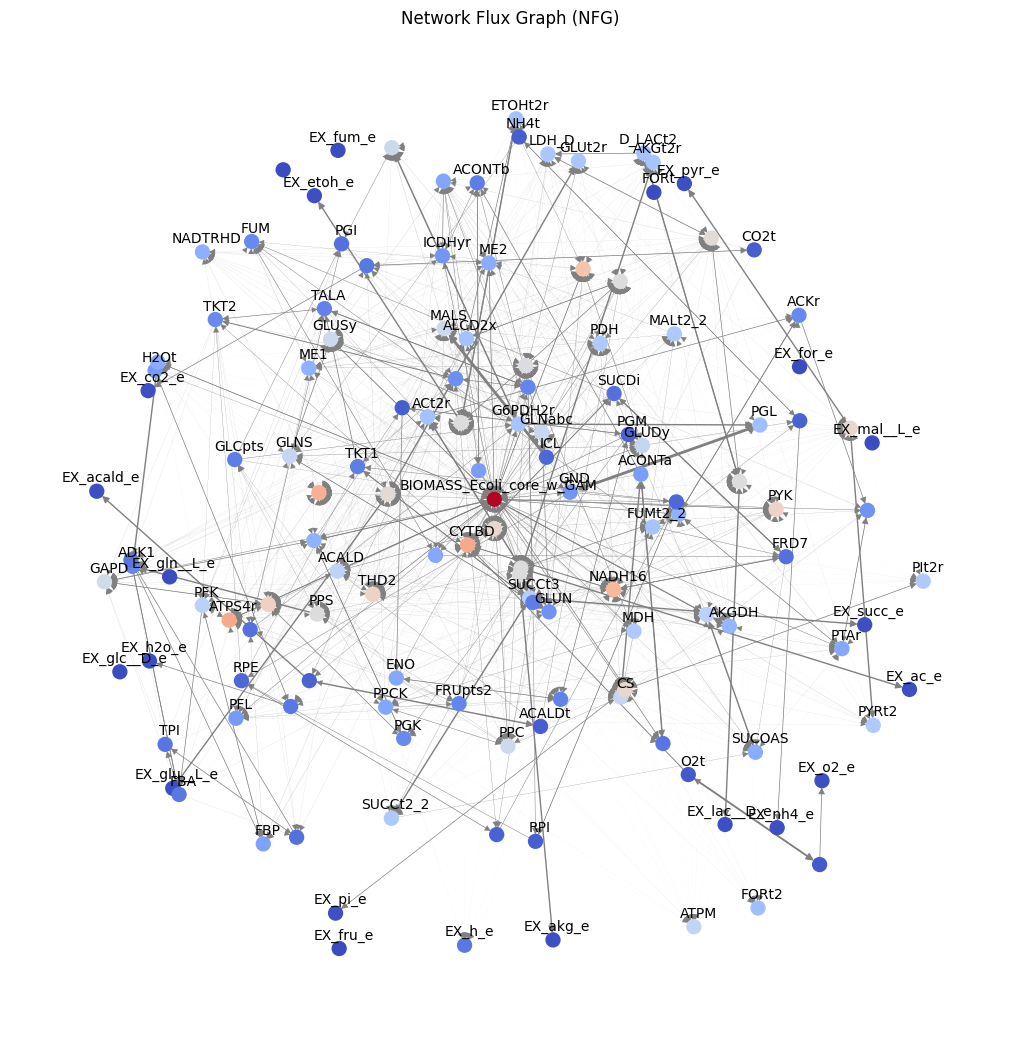

In [57]:
# Convert D matrix into a graph
G = nx.from_numpy_array(D, create_using=nx.DiGraph)
weights = [G[u][v]['weight'] for u,v in G.edges()]
normalized_weights = [(w - min(weights)) / (max(weights) - min(weights)) * (2 - 0.001) + 0.001 for w in weights]



# Create a dictionary mapping node indices to reaction names for labeling
reaction_names = [r.id for r in model.reactions]
node_labels = {i: reaction_name for i, reaction_name in enumerate(reaction_names)}

# Calculate the degrees of each node
degrees = [val for (node, val) in G.degree()]

# Normalize the degrees for color mapping
normalized_degrees = [(d - min(degrees)) / (max(degrees) - min(degrees)) for d in degrees]

# Use a colormap to map normalized degrees to colors
cmap = plt.get_cmap('coolwarm')  # Choose a colormap here
node_colors = [cmap(deg) for deg in normalized_degrees]


# Plot the graph
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G)  # Position nodes using Fruchterman-Reingold force-directed algorithm.
nx.draw(G, pos, width=normalized_weights, node_color=node_colors, edge_color='gray', node_size=100)

#Labels
reaction_names = [r.id for r in model.reactions]
node_labels = {i: reaction_name for i, reaction_name in enumerate(reaction_names)}
label_pos = {node: (x + 0.01, y + 0.03) for node, (x, y) in pos.items()} 
nx.draw_networkx_labels(G, label_pos, labels=node_labels, font_size=10)

plt.title('Network Flux Graph (NFG)')
plt.show()


In [39]:
D

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        5.73861745e-06, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.82349794e-04, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [7]:
FluxOpenValue

NameError: name 'FluxOpenValue' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.linalg import pinv
import cobra

# Load the model (Assuming SBML format)
modelD2 = cobra.io.read_sbml_model('/Users/pablodigiusto/Downloads/e_coli_core.xml')

# Extract stoichiometric matrix and other useful quantities
S = cobra.util.array.create_stoichiometric_matrix(modelD2)
n, m = S.shape

# Create S2m matrix
r = np.array([reaction.reversibility for reaction in modelD2.reactions])
Im = np.eye(m)
diagR = r * Im
S2m2 = np.block([[Im, np.zeros((m, m))], [np.zeros((m, m)), np.diag(r)]])
S2m1 = np.hstack((S, -S))
S2m = S2m1 @ S2m2

# Create S2mplus and S2mminus matrices
S2mplus = (np.abs(S2m) + S2m) / 2
S2mminus = (np.abs(S2m) - S2m) / 2

# Calculate weights
Wplus = pinv(np.diag(S2mplus @ np.ones((2*m, 1))).flaten())
Wminus = pinv(np.diag(S2mminus @ np.ones((2*m, 1))))

# Calculate D matrix
D = 1/n * (Wplus @ S2mplus).T @ (Wminus @ S2mminus)

# Remove unused reactions
IDr = np.nonzero(np.sum(D, axis=0) == 0)[0]
IDr = IDr[IDr > m]

D = np.delete(D, IDr, axis=0)
D = np.delete(D, IDr, axis=1)

# Convert D matrix into a graph
G = nx.from_numpy_array(D, create_using=nx.DiGraph)
weights = [G[u][v]['weight'] for u,v in G.edges()]

# Plot the graph
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G)  # Position nodes using Fruchterman-Reingold force-directed algorithm.
nx.draw(G, pos, with_labels=True, width=weights, node_size=500)
plt.title('Network Flux Graph (NFG)')
plt.show()

# Initialize the pagerank list
pagerank = []

# Process each flux distribution in FluxOpenValue
for v1 in FluxOpenValue:
    # Unfold the flux vector
    vplus = (np.abs(v1) + v1) / 2
    vminus = (np.abs(v1) - v1) / 2
    v2m = np.hstack((vplus, vminus))

    # Calculate Jv
    J_v = S2mplus @ v2m.T

    # Calculate M matrix
    M = (S2mplus * v2m).T @ pinv(np.diag(J_v)) @ (S2mminus * v2m)
    
    # Convert M matrix into a graph
    G = nx.from_numpy_array(M, create_using=nx.DiGraph)
    pr = nx.pagerank_numpy(G)
    pagerank.append(pr)

    # Plot the graph
    weights = [G[u][v]['weight'] for u,v in G.edges()]
    plt.figure(figsize=(10,10))
    nx.draw(G, pos, with_labels=True, node_color=np.log(list(nx.pagerank(G).values())), cmap=plt.get_cmap('rainbow'), width=weights, node_size=500)
    plt.colorbar()
    plt.title('Metabolic Flux Graph (MFG) for FluxOpenValue index {}'.format(i))
    plt.show()

# Process pagerank results
pagerank = np.array(pagerank).T
pagerank_rxns = pagerank[:m, :]
pagerank_rxns_back = pagerank[m:, :]
for i in range(m):
    pagerank_rxns[i, :] = np.maximum(pagerank_rxns[i, :], pagerank_rxns_back[i, :])


In [ ]:
import numpy as np
import networkx as nx
import pandas as pd
from scipy.linalg import pinv2
from cobra.io import read_sbml_model

model = read_sbml_model('/Users/pablodigiusto/Downloads/e_coli_core.xml')

solution = model.optimize()
FluxOpenValue = solution.fluxes

# Stoichiometric Matrix
S = cobra.util.create_stoichiometric_matrix(model, array_type='dense')
# definition of number of metabolites and reactions
n, m = S.shape


# Calculate NFG
Im = np.eye(m)
r = np.array([int(reaction.reversibility) for reaction in model.reactions])
diagR = r * Im
S2m2 = np.block([[Im, np.zeros((m, m))], [np.zeros((m, m)), diagR]])
S2m1 = np.block([S, -S])
S2m = S2m1 @ S2m2
S2mplus = (np.abs(S2m) + S2m) / 2
S2mminus = (np.abs(S2m) - S2m) / 2
Wplus = pinv2(np.diag(S2mplus @ np.ones((2*m, 1))))
Wminus = pinv2(np.diag(S2mminus @ np.ones((2*m, 1))))
D = 1/n * (Wplus @ S2mplus).T @ (Wminus @ S2mminus)
IDr = np.where(np.sum(D, axis=0) == 0)[0]
IDr = IDr[IDr > m]
D = np.delete(D, IDr, axis=0)
D = np.delete(D, IDr, axis=1)
rxns = [reaction.id for reaction in model.reactions]
rxns = np.delete(rxns, IDr-m, axis=0)

# Plot the graph
G = nx.from_numpy_matrix(D, create_using=nx.DiGraph())
nx.set_node_attributes(G, {i: n for i, n in enumerate(np.concatenate([rxns, np.char.add(rxns, '_r')]))}, 'Name')
edge_weights = nx.get_edge_attributes(G, 'weight')
max_weight = max(edge_weights.values())
nx.set_edge_attributes(G, {e: w / max_weight for e, w in edge_weights.items()}, 'LWidths')

# PageRank calculations
PageRank = []
for v1 in FluxOpenValue.T:  # Assuming FluxOpenValue is defined
    vplus = (np.abs(v1) + v1) / 2
    vminus = (np.abs(v1) - v1) / 2
    v2m = np.concatenate([vplus, vminus])
    J_v = S2mplus @ v2m.T
    M = (S2mplus @ np.diag(v2m)).T @ pinv2(np.diag(J_v)) @ (S2mminus @ np.diag(v2m))
    G = nx.from_numpy_matrix(M, create_using=nx.DiGraph())
    nx.set_node_attributes(G, {i: n for i, n in enumerate(np.concatenate([rxns, np.char.add(rxns, '_r')]))}, 'Name')
    pr = nx.pagerank(G)
    PageRank.append(pr)

PageRank = np.array(PageRank).T
PageRankRxns = PageRank[:m, :]
PageRankRxns_back = PageRank[m:, :]
for i in range(m):
    for j in range(PageRankRxns.shape[1]):
        if PageRankRxns_back[i, j] > PageRankRxns[i, j]:
            PageRankRxns[i, j] = PageRankRxns_back[i, j]
